In [29]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchviz import make_dot


In [57]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x
    
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=(2,2), stride=(2, 2))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        return x

In [30]:
net = Net()
x = Variable(torch.rand(1, 3))
y = net(x)

In [25]:
test = torch.jit.trace(net, x)
test.graph

graph(%self.1 : __torch__.___torch_mangle_27.Net,
      %input.1 : Float(1:3, 3:1, requires_grad=0, device=cpu)):
  %53 : __torch__.torch.nn.modules.activation.___torch_mangle_23.ReLU = prim::GetAttr[name="relu3"](%self.1)
  %52 : __torch__.torch.nn.modules.linear.___torch_mangle_26.Linear = prim::GetAttr[name="fc3"](%self.1)
  %49 : __torch__.torch.nn.modules.activation.___torch_mangle_22.ReLU = prim::GetAttr[name="relu2"](%self.1)
  %48 : __torch__.torch.nn.modules.linear.___torch_mangle_25.Linear = prim::GetAttr[name="fc2"](%self.1)
  %45 : __torch__.torch.nn.modules.activation.___torch_mangle_21.ReLU = prim::GetAttr[name="relu"](%self.1)
  %44 : __torch__.torch.nn.modules.linear.___torch_mangle_24.Linear = prim::GetAttr[name="fc1"](%self.1)
  %60 : Tensor = prim::CallMethod[name="forward"](%44, %input.1)
  %61 : Tensor = prim::CallMethod[name="forward"](%45, %60)
  %62 : Tensor = prim::CallMethod[name="forward"](%48, %61)
  %63 : Tensor = prim::CallMethod[name="forward"](%49, %62)


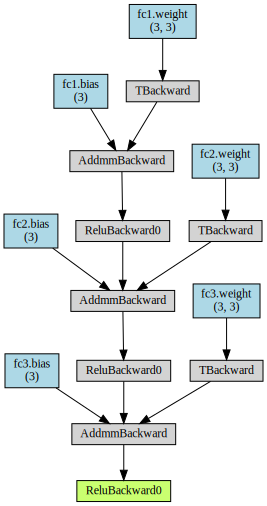

In [31]:
make_dot(y, params=dict(net.named_parameters()))
# make_dot(net(x), params=dict(net.named_parameters()))

In [28]:
# for v in y:
#     if hasattr(v, 'next_functions'):
#         print(v.next_functions)

In [21]:
# var = net(x)
# output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)

In [32]:
if isinstance(y, tuple):
    for v in y:
        print(v.grad_fn)
#         add_nodes(v.grad_fn)
# else:
#         add_nodes(var.grad_fn)

In [33]:
var = y

In [55]:
output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)
seen = set()
params = dict(net.named_parameters())
param_map = {id(v): k for k, v in params.items()}
count = 0

def size_to_str(size):
    return '(' + (', ').join(['%d' % v for v in size]) + ')'


def add_nodes(var):
    global count
    print(f'count: {count}')
    count += 1
    if var not in seen:
        if torch.is_tensor(var):
            
            print(f'var is tensor!! node: {str(id(var))}, size: {size_to_str(var.size())}')
            # note: this used to show .saved_tensors in pytorch0.2, but stopped
            # working as it was moved to ATen and Variable-Tensor merged
#             dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')

        elif hasattr(var, 'variable'):
            u = var.variable
            name = param_map[id(u)] if params is not None else ''
            print(f'var has variable!! node_name: {name}, size: {size_to_str(u.size())}')
            
        elif var in output_nodes:
            print(f'output_node: {str(type(var).__name__)}')
            
        else:
            print(f'other !! {str(type(var).__name__)}')
            
        seen.add(var)
        
        if hasattr(var, 'next_functions'):
            for u in var.next_functions:
                if u[0] is not None:
                    print(f'next_functions !! edge: {str(id(u[0]))}-{str(id(var))}')
                    add_nodes(u[0])
                    
        if hasattr(var, 'saved_tensors'):
            for t in var.saved_tensors:
                print(f'saved_tensors !! edge: {str(id(t))}-{str(id(var))}')
                add_nodes(t)
        
        

In [52]:
param_map

{140431373101312: 'fc1.weight',
 140431373099904: 'fc1.bias',
 140431373102784: 'fc2.weight',
 140431374719424: 'fc2.bias',
 140431374719168: 'fc3.weight',
 140431377319744: 'fc3.bias'}

In [56]:
if isinstance(var, tuple):
    for v in var:
        add_nodes(v.grad_fn)
else:
    add_nodes(var.grad_fn)

count: 0
output_node: ReluBackward0
next_functions !! edge: 140431367978336-140431367823216
count: 1
other !! AddmmBackward
next_functions !! edge: 140431367976176-140431367978336
count: 2
var has variable!! node_name: fc3.bias, size: (3)
next_functions !! edge: 140431367819616-140431367978336
count: 3
other !! ReluBackward0
next_functions !! edge: 140431367976032-140431367819616
count: 4
other !! AddmmBackward
next_functions !! edge: 140431367975744-140431367976032
count: 5
var has variable!! node_name: fc2.bias, size: (3)
next_functions !! edge: 140431367978576-140431367976032
count: 6
other !! ReluBackward0
next_functions !! edge: 140431368006432-140431367978576
count: 7
other !! AddmmBackward
next_functions !! edge: 140431368007008-140431368006432
count: 8
var has variable!! node_name: fc1.bias, size: (3)
next_functions !! edge: 140431368004080-140431368006432
count: 9
other !! TBackward
next_functions !! edge: 140431367978480-140431368004080
count: 10
var has variable!! node_name:

In [60]:
net2 = Net2()
x = Variable(torch.rand(1, 1, 4, 4))
y = net2(x)

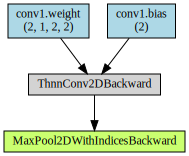

In [61]:
make_dot(y, params=dict(net2.named_parameters()))